In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imwrite, imread
from scripts.sample_db import SampleDB


In [4]:

def load_traces(traces_file_path, as_df=False):
    traces_dict =  {id: trace for id, trace in np.load(traces_file_path, allow_pickle=True).item().items()}
    traces_df = pd.DataFrame.from_dict(trial_fluorescence, orient='index')
    return traces_df if as_df else traces_dict
# Example of loading and plotting fluorescence data


def plot_fluorescence_data(traces_file_path):
    trial_fluorescence = np.load(traces_file_path, allow_pickle=True).item()
    np_traces = np.array(list(trial_fluorescence.values()))
    
    plt.figure(figsize=(10, 5))
    for trace in np_traces:
        plt.plot(trace, alpha=0.5)
    
    mean_traces = np.mean(np_traces, axis=0)
    plt.plot(mean_traces, color='black', linewidth=2, label='Mean Trace')
    plt.legend()
    plt.title('Fluorescence Traces')
    plt.xlabel('Frame')
    plt.ylabel('Fluorescence Intensity')
    plt.show()
    

In [ ]:

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

# Load experiment
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Shortcuts for sample parameters
sample = exp.sample
raw_path = exp.paths["raw_path"]
anatomy_path = exp.paths["anatomy_path"]
em_path = exp.paths["em_path"]
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Get paths of the trial acquisitions
trial_paths = [os.path.splitext(path)[0] for path in os.listdir(os.path.join(raw_path, "trials"))]
print(trial_paths)

# Define paths for preprocessed and masks folders
preprocessed_folder = os.path.join(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3", "preprocessed")
os.makedirs(preprocessed_folder, exist_ok=True)
masks_folder = os.path.join(preprocessed_folder, "..", "masks")
os.makedirs(masks_folder, exist_ok=True)

# Load masks
all_masks = []
for plane in range(n_planes*doubling):
    plane_str = f"{plane:02d}"
    mask_path = os.path.join(masks_folder, f"mask_plane_{plane_str}.tif")
    masks = imread(mask_path)
    all_masks.append(masks)
all_masks = np.array(all_masks)

# Create folder for saving fluorescence data
traces_folder = os.path.join(preprocessed_folder, "..", "traces")
os.makedirs(traces_folder, exist_ok=True)

# Calculate and save fluorescence intensity
for plane in range(n_planes*doubling):
    plane_str = f"{plane:02d}"
    for trial_idx, trial_path in enumerate(trial_paths):
        movie_path = os.path.join(preprocessed_folder, f"transformed_plane_{plane_str}_{trial_path}.tif")
        movie = imread(movie_path)
        mask = all_masks[plane, trial_idx,:,:]

        trial_fluorescence = {}
        for label in np.unique(mask):
            if label != 0:
                label_mask = mask == label
                fluorescence_values = movie[:, label_mask].mean(axis=1)
                trial_fluorescence[label] = fluorescence_values
        
        # Save the fluorescence data for the current plane and trial
        traces_file_path = os.path.join(traces_folder, f"traces_plane_{plane_str}_{trial_path}.npy")
        np.save(traces_file_path, trial_fluorescence)
        print(f"Fluorescence data saved at {traces_file_path}")


print("Fluorescence intensities calculated and saved.")



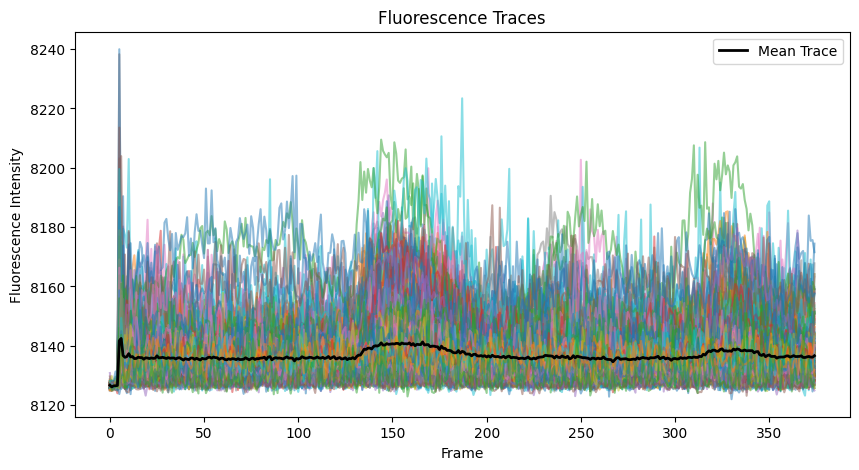

In [5]:

# Example path to a fluorescence data file
traces_file_path = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\..\masks\traces\traces_plane_03_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.npy"
plot_fluorescence_data(traces_file_path)
